1: We first import the required modules

In [1]:
from unityagents import UnityEnvironment
import gym
import random
import torch
from torch.autograd import Variable
from torch import nn
from torchviz import make_dot, make_dot_from_trace
from model import DuelingDQN
from model import DQN
from torch.autograd import Variable
from torchviz import make_dot
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline


2: Before you run the next cell make sure you have done the following:
- Downloaded the required environment for your operating system. Details in README.MD
- Extracted the enviroment and placed folder into same directory as results.ipynb
- Change the arg: "file_name" below to the correct environment path if required. 

The following cell initiates the Unity environment 

In [2]:
env = UnityEnvironment(file_name="Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


3:Now we create the brain to interact with the environment

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

4: Next cell provides a simple example of the environment and prints out the following:
- Number of Agents(brains), 
- The number of actions 4(forwards, backward, left, right) 
- The State as a vector
- the length of the State vector

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


We now import the Agent and assign it a variable

There are three implementation that can be called with the arg:network
- "dqn" = Vanilla DQN
- "double" = Double DQN
- "duel" = Dueling DQN

The Hyperparamters for all Agents variations have been set to the following. I played with the hyperparamters and trainined endless versions but decied these worked the best. If getting to the score of 13 was the most important than increasing the TAU or LR increased the traninig speeds but did not reach as high scores. A score of 13 could be achieved in as little as 122 episodes but this varied massivly between each training. The below achieved very consistant scores that trained fast and achieved a final score of 17 or more. 

- BUFFER_SIZE = 100000   (replay buffer size)
- BATCH_SIZE = 64         (minibatch size)
- GAMMA = 0.99            (discount factor
- TAU = 0.001             for soft update of target parameters
- LR = 0.0005             learning rate 
- UPDATE_EVERY = 4        how often to update the network

The network architecture for each variation

Vanilla DQN




In the end the final implementation and best performing was the Dueling DQN. I

Lets take a look at the base DQN model
the model  has 3 fully connected layers with 64 nodes each. It takes an input of 37 (state vector) and output of 4 (action space)
It uses Rulu activation on the first two layers and Adam Optermizer.

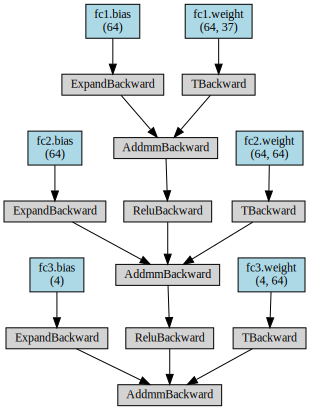

In [9]:
model = DQN(37, 4, 42)
x = Variable(torch.randn(1,37))
y = model(x)
             
make_dot(y, params=dict(list(model.named_parameters())))

In [ ]:
Lets take a look at the Dueling DQN model.

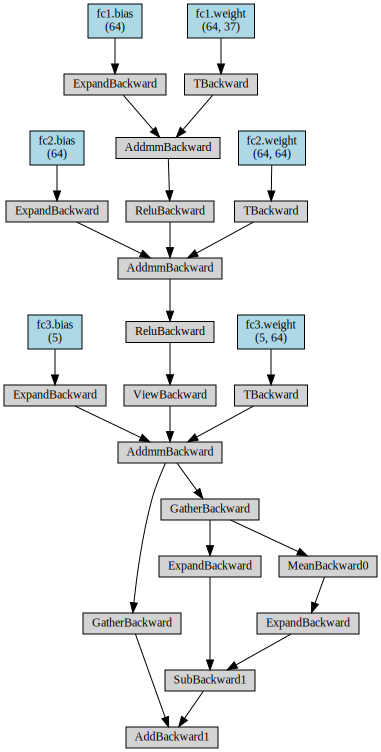

In [7]:

model = DuelingDQN(37, 4, 42)
x = Variable(torch.randn(1,37))
y = model(x)
             
make_dot(y, params=dict(list(model.named_parameters())))

In [5]:
from agent import Agent

agent = Agent(state_size=state_size, action_size=action_size, seed=0, network="duel")

Now we run the Deep Q-Learning algorithm and training steps:

Episode 100	Average Score: 2.40
Episode 200	Average Score: 4.74
Episode 300	Average Score: 11.63
Episode 400	Average Score: 14.85
Episode 500	Average Score: 15.69
Episode 600	Average Score: 16.50
Episode 700	Average Score: 16.62
Episode 735	Average Score: 17.00
Environment solved in 635 episodes!	Average Score: 17.00


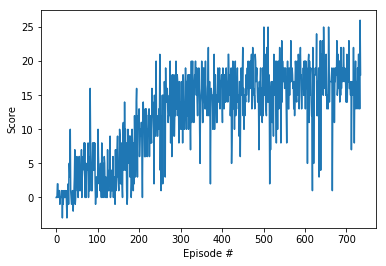

In [6]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]  
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=17.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Results
The environment is solved with a score of 13+ over 100 conseculative episodes, but this seems too easy so I set it to 17 for little challenge. 






We now load the saved weights for the network

In [7]:
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

Now sit back and watch the MASTER trained network collect Bannanas.

In [9]:

# watch the Master agent
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state)
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 20.0


In [ ]:
env.close()